In [2]:
%matplotlib inline

In [4]:
import sys
sys.path.append('../src/')

import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import curve_fit, minimize
from scipy import integrate,interpolate

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray
import gsw

from sklearn.linear_model import LinearRegression

from epsilon_tools import *
# from tools import str2date, avg_funs

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 4])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

In [5]:
file = '../data/goship/selected/P01_20070724_00011_00001_ct1.csv'
data = pd.read_csv(file,header=17,skipfooter=1,engine='python')
# data = data.drop(columns=['Unnamed: 1','Unnamed: 3','Unnamed: 5','Unnamed: 7','Unnamed: 8','ML/L'])
data = data.drop(columns=['Unnamed: 1','Unnamed: 3','Unnamed: 5','Unnamed: 7','Unnamed: 9','Unnamed: 10','MG/M^3','UMOL/KG'])
data.rename(columns={'ITS-90':'tmp','PSS-78':'sal','DBAR':'prs'},inplace=True)

In [6]:
lon0 = 146.3
lat0 = 41.9
data['sal'] = gsw.SA_from_SP(data.sal,data.prs,lon0,lat0)
data['tmp'] = gsw.CT_from_t(data.sal,data.tmp,data.prs)
data['rho'] = gsw.rho(data.sal,data.tmp,3000)
data['z'] = gsw.z_from_p(data.prs, lat0)

In [7]:
bins = np.arange(0,6000,2)
data = data.groupby(pd.cut(data.prs,bins)).mean()

In [8]:
ds = pd.DataFrame()
ds['N2'],ds['pmid']= gsw.Nsquared(data.sal,data.tmp,data.prs,lat=40)
ds['z'] = gsw.z_from_p(ds.pmid, lat0)

In [9]:
ds = ds.rolling(window=10,center=True,win_type='hamming').mean()
N0 = np.nanmean( np.sqrt(ds.N2) )
ds['N/N0'] = np.sqrt(ds.N2)/N0

### GO-SHIP full-depth T,S,$\rho$ profiles

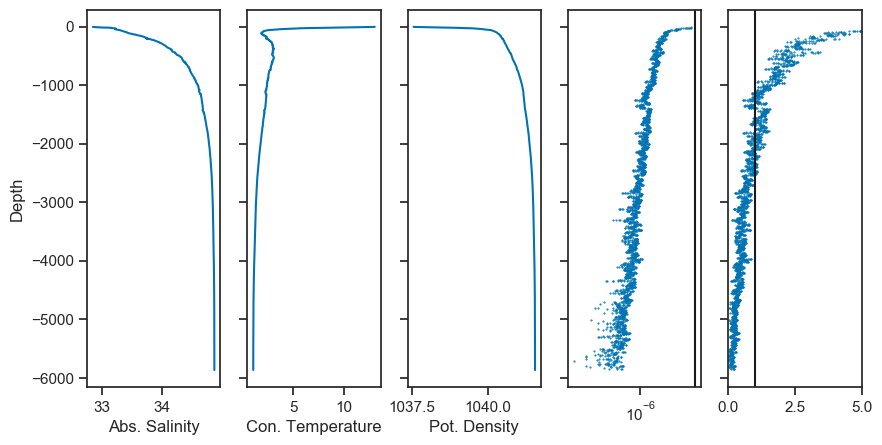

In [10]:
f,ax = plt.subplots(1,5,sharey=True, figsize=(10,5))
ax[0].plot(data.sal,data.z,'-')
ax[0].set_ylabel('Depth')
ax[0].set_xlabel('Abs. Salinity')
ax[1].plot(data.tmp,data.z,'-')
ax[1].set_xlabel('Con. Temperature')
ax[2].plot(data.rho,data.z,'-')
ax[2].set_xlabel('Pot. Density')

ax[3].plot(ds.N2,ds.z,'.', markersize=1)
ax[3].axvline(N0,color='k')
ax[3].set_xscale('log')
# ax[3].set_xlim(5e-4,1e-2);

ax[4].plot(ds['N/N0'],ds.z,'.', markersize=1)
ax[4].axvline(N0/N0,color='k')
# ax[4].set_xscale('log')
ax[4].set_xlim(0,5);

# plt.ylim(-1000,0)

### WKB-streched depth z':
$$
z'(z) = \int_0^z \frac{N(z)}{<N>} dz
$$

In [11]:
ds = ds.sort_values('z',ascending=False)
ds = ds.dropna()
zmid = 0.5*( ds.z.values[0:-1] + ds.z.values[1:])
zprime = integrate.cumtrapz(ds['N/N0'],ds['z'])

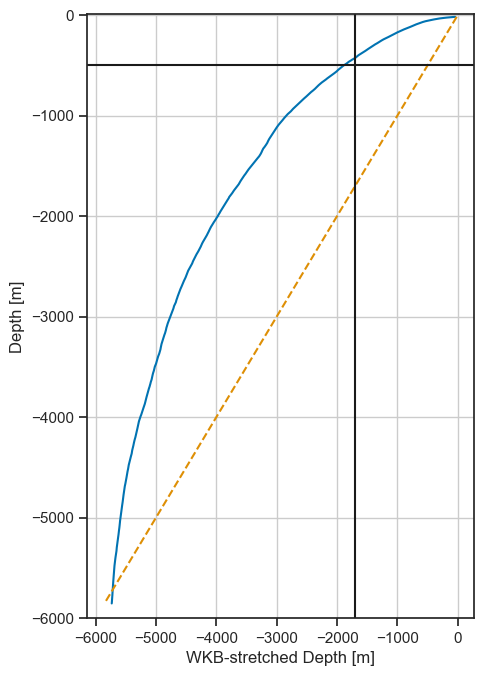

In [12]:
plt.figure(figsize=(5,8))
plt.plot(zprime,zmid)
plt.plot(zmid,zmid,linestyle='dashed')
plt.axhline(-500, color='k')
plt.axvline(-1700, color='k')
# plt.annotate('max. z observation',(-6000,-400))
plt.ylabel('Depth [m]')
plt.xlabel("WKB-stretched Depth [m]")
plt.grid()
plt.ylim(-6000,10);

In [13]:
fraction_resolved = -100*1700/ds.z.min()
print(f'Fraction of the water column resolved: {fraction_resolved:2.2f}%')

Fraction of the water column resolved: 29.01%


### Vertical IW modes for N=const

Equation for vertical structure W from ansatz in wave equation:
$$
\frac{d^2W}{dz^2} + k^2 \left( \frac{N^2}{\omega^2} -1 \right)W = 0
$$
with
$$
W = 0,~ z=-D
$$
and
$$
\omega^2\frac{dW}{dz} - gk^2W = 0,~ z=0
$$

In [15]:
D = -ds.z.min()
W = np.zeros((len(zprime),5))
for j in [1,2,3,4,5]:
    W[:,j-1] = (-1)**j*np.cos(j*np.pi*zprime/D)

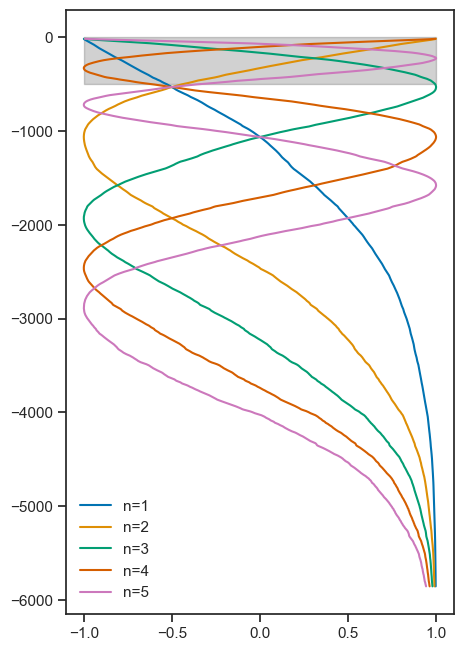

In [17]:
plt.figure(figsize=(5,8))
plt.plot(W,zmid)
plt.legend(labels=['n=1','n=2','n=3','n=4','n=5']);
plt.fill_between([-1,1],y1=-500,y2=0,alpha=0.2, color='k');

In [19]:
W.shape

(2913, 5)

In [20]:
raw = xr.open_dataset('../data/raw_temp.nc')

In [21]:
raw

<xarray.Dataset>
Dimensions:        (time: 215, z: 501)
Coordinates:
  * time           (time) datetime64[ns] 2016-10-04T00:39:31.322976 ... 2016-10-19T22:42:41.728779
  * z              (z) float64 -0.0 -1.985 -3.969 ... -986.0 -988.0 -989.9
    pressure       (z) float64 ...
    lat            (time) float64 ...
    lon            (time) float64 ...
    dtime          (time) float64 ...
Data variables:
    sigma          (z, time) float64 ...
    T              (z, time) float64 ...
    S              (z, time) float64 ...
    n2             (z, time) float64 ...
    rho0           (z, time) float64 ...
    u              (z, time) float64 ...
    v              (z, time) float64 ...
    dudz           (z, time) float64 ...
    dvdz           (z, time) float64 ...
    S2             (z, time) float64 ...
    mld            (time) float64 ...
    uNI            (z, time) float64 ...
    vNI            (z, time) float64 ...
    u_surf         (time) float64 ...
    v_surf         (time) float64 ...
    u_surf_ni      (time) float64 ...
    v_surf_ni      (time) float64 ...
    tx             (time) float64 ...
    ty             (time) float64 ...
    txNI           (time) float64 ...
    tyNI           (time) float64 ...
    taudotu        (time) float64 ...
    taudotu_ni     (time) float64 ...
    taudotu_ni_ni  (time) float64 ...
    tau            (time) float64 ...
    dudzNI         (z, time) float64 ...
    dvdzNI         (z, time) float64 ...
    SNI            (z, time) float64 ...
    hkeNI          (z, time) float64 ...
    hkeTOT         (z, time) float64 ...
    hke_ml_ni      (time) float64 ...
    hke_py_ni      (time) float64 ...
    hke_ml         (time) float64 ...
    hke_py         (time) float64 ...
    dhke_ml        (time) float64 ...
    dhke_ml_ni     (time) float64 ...
    dhke_py        (time) float64 ...
    dhke_py_ni     (time) float64 ...
    rho0LOW        (z, time) float64 ...
    rho_ref        (z, time) float64 ...
    rho_prime      (z, time) float64 ...
    ape            (z, time) float64 ...
    hke_ape        (z, time) float64 ...
    ape_ml         (time) float64 ...
    ape_py         (time) float64 ...
    dape_ml        (time) float64 ...
    dape_py        (time) float64 ...
    kT             (z, time) float64 ...
    chi            (z, time) float64 ...
    eps            (z, time) float64 ...
    eps_ml         (time) float64 ...
    eps_py         (time) float64 ...
    ang            (z, time) float64 ...
    angS           (z, time) float64 ...
    ang_br         (z, time) float64 ...
    angS_br        (z, time) float64 ...
    sigma_ref      (z, time) float64 ...
    zmap           (z, time) float64 ...
    eta            (z, time) float64 ...
    eta_ape        (z, time) float64 ...
Attributes:
    floatid:  7781a